In [48]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from src.models.train import train_single_model
from src.models.utils import milling_add_y_label_anomaly, get_model_metrics_df
from ast import literal_eval
from src.visualization.visualize import plot_pr_roc_curves_kfolds
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
proj_dir = Path.cwd().parent.parent.parent
scratch_dir = Path.home() / "scratch"

In [76]:
df = pd.read_csv('compiled_results.csv',)
df = df[df['scaler_method'] != "minmax"].reset_index(drop=True)
df.head()

,uo_method,scaler_method,imbalance_ratio,classifier,sampler_seed,feat_col_list,date_time,dataset,precision_score_min,precision_score_max,...,SGDClassifier_loss,SGDClassifier_penalty,RandomForestClassifier_bootstrap,RandomForestClassifier_class_weight,RandomForestClassifier_criterion,RandomForestClassifier_max_depth,RandomForestClassifier_min_samples_leaf,RandomForestClassifier_min_samples_split,RandomForestClassifier_n_estimators,SVC_degree
0,smote,standard,0.7,knn,3611799,"['smcdc__kurtosis', 'smcac__kurtosis', 'vib_sp...",2022-05-04-1150-40,milling,1.000000,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,smote,standard,0.7,rf,24069445,"['smcdc__kurtosis', 'smcac__kurtosis', 'vib_sp...",2022-05-04-1150-40,milling,0.404096,0.414997,...,NaN,NaN,True,balanced_subsample,entropy,411.0,9.0,3.0,460.0,NaN
2,NaN,standard,0.5,svm,14188175,"['smcdc__kurtosis', 'smcac__kurtosis', 'vib_sp...",2022-05-04-1150-40,milling,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,random_under,standard,0.5,ridge,20394116,"['smcdc__kurtosis', 'smcac__kurtosis', 'vib_sp...",2022-05-04-1150-40,milling,0.122677,0.196796,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,smote,standard,0.3,lr,9519807,"['smcdc__kurtosis', 'smcac__kurtosis', 'vib_sp...",2022-05-04-1150-40,milling,0.111231,0.161108,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
mill_feature_path = scratch_dir / "feat-store" / "data/processed/milling/milling_features.csv.gz"
df_feat = pd.read_csv(mill_feature_path, compression='gzip')
df_feat = milling_add_y_label_anomaly(df_feat)
print(df_feat["y"].unique())
df_feat.head()

[0 1]


,cut_id,ae_spindle__length,ae_spindle__kurtosis,ae_table__length,ae_table__kurtosis,vib_spindle__length,vib_spindle__kurtosis,vib_table__length,vib_table__kurtosis,smcdc__length,smcdc__kurtosis,smcac__length,smcac__kurtosis,cut_no,case,tool_class,y
0,50_23,64.0,-0.536421,64.0,1.023564,64.0,0.052618,64.0,-1.182274,64.0,-0.741543,64.0,-1.379993,50,4,1,0
1,50_24,64.0,0.580646,64.0,-0.248433,64.0,-0.477432,64.0,-1.185010,64.0,-0.906486,64.0,-1.373383,50,4,1,0
2,50_25,64.0,-0.335575,64.0,-0.117931,64.0,0.385026,64.0,-1.320485,64.0,-1.051426,64.0,-1.398157,50,4,1,0
3,50_26,64.0,-1.180998,64.0,-0.227941,64.0,0.198078,64.0,-1.123297,64.0,-0.680110,64.0,-1.348922,50,4,1,0
4,50_27,64.0,-0.074406,64.0,-0.431231,64.0,-0.430192,64.0,-1.300146,64.0,-0.387458,64.0,-1.363613,50,4,1,0


In [78]:
def rebuild_params_clf(df, row_idx):
    classifier_string = df.iloc[row_idx]['classifier']
    if classifier_string == "rf":
        prefix = 'RandomForestClassifier'

    elif classifier_string == "xgb":
        prefix = 'XGB'

    elif classifier_string == "knn":
        prefix = 'KNeighborsClassifier'

    elif classifier_string == "lr":
        prefix = 'LogisticRegression'

    elif classifier_string == "sgd":
        prefix = 'SGDClassifier'

    elif classifier_string == "ridge":
        prefix = 'RidgeClassifier'

    elif classifier_string == "svm":
        prefix = 'SVC'

    elif classifier_string == "nb":
        prefix = 'GaussianNB'

    params_clf = {c.replace(f"{prefix}_",""): df.iloc[row_idx][c]  for c in df.iloc[row_idx].dropna().index if c.startswith(prefix)}

    # convert any whole numbers in clf_cols to int
    for k in params_clf.keys():
        if isinstance(params_clf[k], float) and params_clf[k].is_integer():
            params_clf[k] = int(params_clf[k])

    return {k: [params_clf[k]] for k in params_clf.keys()} # put each value in a list

def rebuild_general_params(df, row_idx, general_param_keys=None):
    if general_param_keys is None:
        general_param_keys = ['scaler_method', 'uo_method', 'imbalance_ratio', 'classifier']
    return {k: [df.iloc[row_idx][k]] for k in general_param_keys}    

In [80]:
row_idx = 3

params_clf = rebuild_params_clf(df, row_idx)
print(params_clf)

general_params = rebuild_general_params(df, row_idx)
print(general_params)

meta_label_cols = ["cut_id", "cut_no", "case", "tool_class"]
stratification_grouping_col = "cut_no"
y_label_col = "y"
feat_selection = True
feat_col_list = literal_eval(df.iloc[row_idx]["feat_col_list"])
sampler_seed = int(df.iloc[row_idx]["sampler_seed"])
print(sampler_seed)

(
    model_metrics_dict,
    params_dict_clf_named,
    params_dict_train_setup,
    feat_col_list
) = train_single_model(
    df_feat,
    sampler_seed,
    meta_label_cols,
    stratification_grouping_col,
    y_label_col,
    feat_selection,
    feat_col_list,
    general_params=general_params,
    params_clf=params_clf,
)

{'alpha': [4.154462082]}
{'scaler_method': ['standard'], 'uo_method': ['random_under'], 'imbalance_ratio': [0.5], 'classifier': ['ridge']}
20394116
classifier: ridge, uo_method: random_under, imbalance_ratio: 0.5

 {'RidgeClassifier_alpha': 4.154462082}
0
scaling - standard
min x_train -2.7868497764747113
max x_train 42.333429536680384
min x_test -2.7868497764747113
max x_test 42.333429536680384
x_train shape: (2082, 5)
1
scaling - standard
min x_train -2.784962282784538
max x_train 41.49832537682044
min x_test -2.784962282784538
max x_test 41.49832537682044
x_train shape: (2148, 5)
2
scaling - standard
min x_train -2.8023898364477784
max x_train 38.86082519989638
min x_test -2.8023898364477784
max x_test 38.86082519989638
x_train shape: (2082, 5)
3
scaling - standard
min x_train -2.7458886457231673
max x_train 42.108371907821336
min x_test -2.7458886457231673
max x_test 42.108371907821336
x_train shape: (1917, 5)
4
scaling - standard
min x_train -2.7054299570121354
max x_train 44.1064

In [81]:
params_dict_train_setup

{'uo_method': 'random_under',
 'scaler_method': 'standard',
 'imbalance_ratio': 0.5,
 'classifier': 'ridge',
 'sampler_seed': 20394116}

In [82]:
dfr = get_model_metrics_df(model_metrics_dict)
cols_select = list(dfr.columns)

df[cols_select][row_idx:row_idx+1]

,precision_score_min,precision_score_max,precision_score_avg,precision_score_std,recall_score_min,recall_score_max,recall_score_avg,recall_score_std,f1_score_min,f1_score_max,...,prauc_min,prauc_max,prauc_avg,prauc_std,accuracy_min,accuracy_max,accuracy_avg,accuracy_std,n_thresholds_min,n_thresholds_max
3,0.122677,0.196796,0.157074,0.025479,0.046089,0.123919,0.082649,0.02536,0.067005,0.152078,...,0.105609,0.140297,0.11858,0.01268,0.896122,0.905134,0.901591,0.003077,9220,9350


In [83]:
dfr

,precision_score_min,precision_score_max,precision_score_avg,precision_score_std,recall_score_min,recall_score_max,recall_score_avg,recall_score_std,f1_score_min,f1_score_max,...,prauc_min,prauc_max,prauc_avg,prauc_std,accuracy_min,accuracy_max,accuracy_avg,accuracy_std,n_thresholds_min,n_thresholds_max
0,0.122677,0.196796,0.157074,0.025479,0.046089,0.123919,0.082649,0.02536,0.067005,0.152078,...,0.105609,0.140297,0.11858,0.01268,0.896122,0.905134,0.901591,0.003077,9220.0,9350.0


In [84]:
model_metrics_dict.keys()

dict_keys(['precisions_array', 'recalls_array', 'precision_score_array', 'recall_score_array', 'fpr_array', 'tpr_array', 'prauc_array', 'rocauc_array', 'f1_score_array', 'n_thresholds_array', 'accuracy_array'])

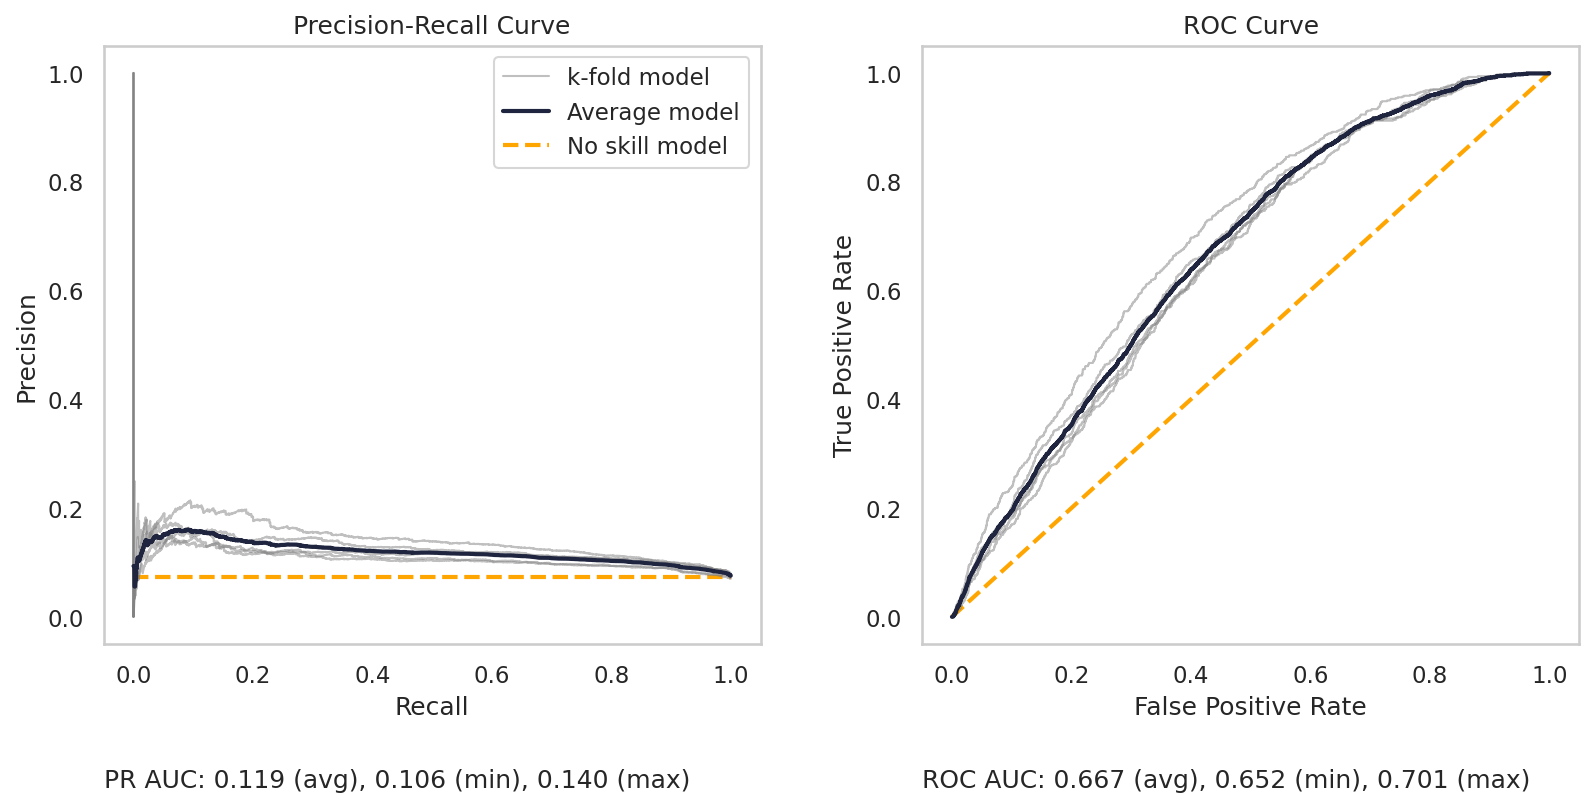

In [85]:
plot_pr_roc_curves_kfolds(
    model_metrics_dict["precisions_array"],
    model_metrics_dict["recalls_array"],
    model_metrics_dict["fpr_array"],
    model_metrics_dict["tpr_array"],
    model_metrics_dict["rocauc_array"],
    model_metrics_dict["prauc_array"],
    percent_anomalies_truth=0.073,
)

In [47]:
print(df.iloc[row_idx]["prauc_avg"])
print(df.iloc[row_idx]["prauc_min"])
print(df.iloc[row_idx]["rocauc_avg"])

0.113482585
0.100452925
0.659100636


In [39]:
df.iloc[row_idx].index

Index(['uo_method', 'scaler_method', 'imbalance_ratio', 'classifier',
       'sampler_seed', 'feat_col_list', 'date_time', 'dataset',
       'precision_score_min', 'precision_score_max', 'precision_score_avg',
       'precision_score_std', 'recall_score_min', 'recall_score_max',
       'recall_score_avg', 'recall_score_std', 'f1_score_min', 'f1_score_max',
       'f1_score_avg', 'f1_score_std', 'rocauc_min', 'rocauc_max',
       'rocauc_avg', 'rocauc_std', 'prauc_min', 'prauc_max', 'prauc_avg',
       'prauc_std', 'accuracy_min', 'accuracy_max', 'accuracy_avg',
       'accuracy_std', 'n_thresholds_min', 'n_thresholds_max', 'SVC_C',
       'SVC_kernel', 'SVC_max_iter', 'SVC_verbose', 'RidgeClassifier_alpha',
       'XGB_alpha', 'XGB_eta', 'XGB_eval_metric', 'XGB_lambda',
       'XGB_max_depth', 'XGB_objective', 'XGB_scale_pos_weight', 'XGB_seed',
       'KNeighborsClassifier_metric', 'KNeighborsClassifier_n_neighbors',
       'KNeighborsClassifier_weights', 'LogisticRegression_class_wei

# Scratch

In [6]:
from src.models.random_search_setup import (
    rf_params,
    xgb_params,
    knn_params,
    lr_params,
    sgd_params,
    ridge_params,
    svm_params,
    nb_params,
    general_params
)

general_params.keys()

dict_keys(['scaler_method', 'uo_method', 'imbalance_ratio', 'classifier'])

In [7]:
general_params_single = {}
for k in general_params.keys():
    general_params_single[k] = [df.iloc[0][k]]

In [8]:
# make a dict comprehension for general_params_single
general_params_single = {k: [df.iloc[0][k]] for k in general_params.keys()}
general_params_single

{'scaler_method': ['minmax'],
 'uo_method': ['smote'],
 'imbalance_ratio': [0.5],
 'classifier': ['svm']}

In [9]:
# find all columns in df that begin with "RandomForestClassifier"
prestring = 'RandomForestClassifier'
clf_cols = {c.replace(f"{prestring}_",""): df.iloc[0][c]  for c in df.iloc[0].dropna().index if c.startswith(prestring)}
clf_cols

{}

In [10]:
# convert any whole numbers in clf_cols to int
for k in clf_cols.keys():
    if isinstance(clf_cols[k], float) and clf_cols[k].is_integer():
        clf_cols[k] = int(clf_cols[k])


In [11]:
clf_cols

{}

In [13]:
params_clf = rebuild_params_clf(df, 0)
params_clf

{'C': [1.31], 'kernel': ['sigmoid'], 'max_iter': [25000], 'verbose': [False]}